In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import os
from glob import glob
from torchvision import datasets, transforms
from torchvision.io import read_image
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error





if torch.cuda.is_available():
    print("Using GPU...")
    dev = "cuda:0"
else:
    print("Using CPU...")
    dev = "cpu"
    
    
device = torch.device(dev)






#Set the random seed for reproducibility 
torch.manual_seed(2020) 



class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # Transform the 28 by 28 image to an embedded code size of 30
            nn.Linear(38400, 30),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 38400),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        # x will be a (batch_size,1,28,28) tensor when using MNIST
        # so we will reshape it to a (batch_size, 28*28) flat tensor.
        # After it has been decoded we will reshape back to the image shape.
        x = self.encoder(x.view(-1, 38400))
        x = self.decoder(x)
        return x.view(-1, 1, 160, 240)




class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),  # activation function
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # conv layer
            nn.ReLU(), # activation function 
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0) # conv layer
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x







class ConvAutoencoder2D(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2D, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),  # activation function
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # conv layer
            nn.ReLU(), # activation function 
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0), # conv layer
            nn.ReLU(),
            #nn.Linear( 64*1*1, 2)
            nn.Linear( 64*1*1, 2)
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Using GPU...


In [2]:
num_epochs = 30
batch_size = 32
    
    
"""
class UCSDAnomalyDataset(data.Dataset):
    '''
    Dataset class to load  UCSD Anomaly Detection dataset
    Input: 
    - root_dir -- directory (Train/Test) structured exactly as out-of-the-box folder downloaded from the site
    http://www.svcl.ucsd.edu/projects/anomaly/dataset.htm
    - time_stride (default 1) -- max possible time stride used for data augmentation
    - seq_len -- length of the frame sequence
    Output:
    - tensor of 10 normlized grayscale frames stiched together
    
    Note:
    [mean, std] for grayscale pixels is [0.3750352255196134, 0.20129592430286292]
    '''
    def __init__(self, root_dir, seq_len = 1, time_stride=1, transform=None):
        super(UCSDAnomalyDataset, self).__init__()
        self.root_dir = root_dir
        vids = [d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, d))]
        self.samples = []
        for d in vids:
            for t in range(1, time_stride+1):
                for i in range(1, 200):
                    if i+(seq_len-1)*t > 200:
                        break
                    self.samples.append((os.path.join(self.root_dir, d), range(i, i+(seq_len-1)*t+1, t)))
        self.pil_transform = transforms.Compose([
                    #transforms.Resize((227, 227)),
                    transforms.Grayscale(),
                    transforms.ToTensor()])
        #self.tensor_transform = transforms.Compose([
        #            transforms.Normalize(mean=(0.3750352255196134,), std=(0.20129592430286292,))])
        
        
    def __getitem__(self, index):
        sample = []
        pref = self.samples[index][0]
        for fr in self.samples[index][1]:
            with open(os.path.join(pref, '{0:03d}.tif'.format(fr)), 'rb') as fin:
                frame = Image.open(fin).convert('RGB')
                frame = self.pil_transform(frame) / 255.0
                #print(frame.shape)
                #frame = self.tensor_transform(frame)
                sample.append(frame)
        sample = torch.stack(sample, axis=0)
        return sample

    def __len__(self):
        return len(self.samples)
"""




class AnomalyDataset(data.Dataset):
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    
    def __getitem__(self, index):
        img_path = self.img_dir[index]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        
        return image
      
      
        



image_path_train = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train_all'
image_paths_train = glob(image_path_train + '/*.tif')
data_transforms = transforms.Compose([transforms.Resize((160, 240)), transforms.ToTensor()])

#dataset = VideoFrameDataset(
#    root_path='./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train',
#    num_segments=5,
#    frames_per_segment=1,
#    imagefile_template='{:03d}.tif',
#    transform=None,
#    test_mode=False
#)


image_path_test = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all'
image_paths_test = glob(image_path_test + '/*.tif')

dataset_train = AnomalyDataset(image_paths_train, data_transforms)
dataset_train2 = AnomalyDataset(image_paths_test, data_transforms)




#dataset = UCSDAnomalyDataset('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train', time_stride=1)
#data_train = data.DataLoader(dataset, batch_size=32, shuffle=True)



In [3]:
def train_AE(model, dataset, max_epochs=20, print_steps=5):
    #Training (optimisation) parameters
    batch_size=64
    learning_rate=1e-3

    #Choose mean square error loss
    criterion = nn.MSELoss() 

    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    #Specify how the data will be loaded in batches (with random shuffling)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Storage
    outputs = []
    
    model.to(device)
    #train_loader = train_loader.cuda()

    #Start training
    for epoch in range(max_epochs):
        for img in train_loader:
            img = img.to(device)
            recon = model(img)
            #print(recon.shape)
            loss = criterion(recon, img.to(device))

            loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
          
        #if ((epoch % print_steps) == 0) or (epoch +1 == max_epochs):
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss.item()))
        outputs.append((epoch, img.detach(), recon.detach()),)

    return outputs

==========PCA TRAIN==========


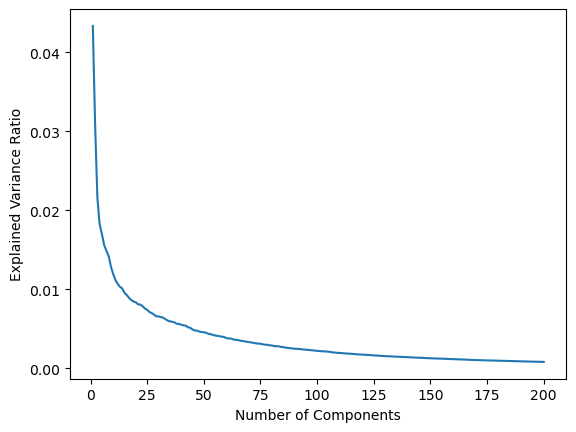

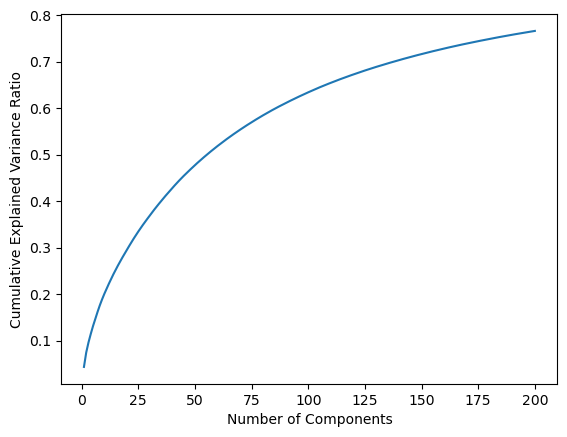

Reconstruction error is  0.0009060024





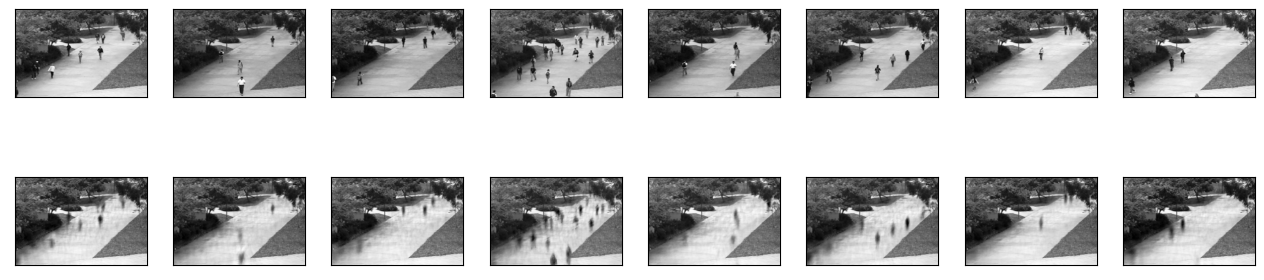

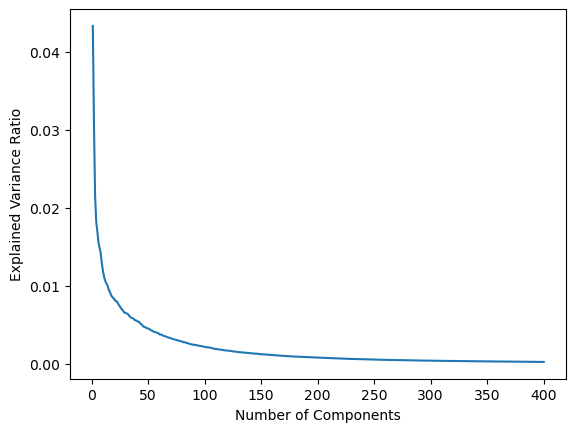

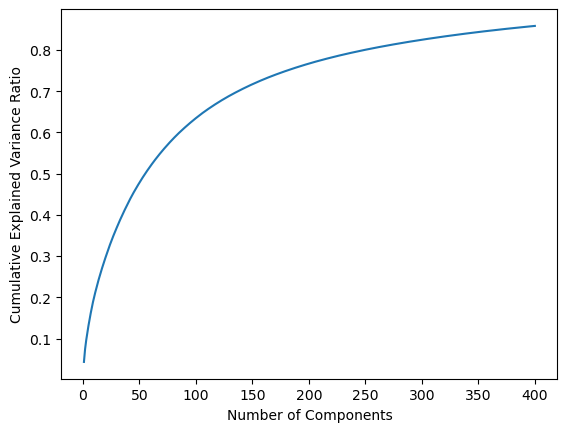

Reconstruction error is  0.0005500417





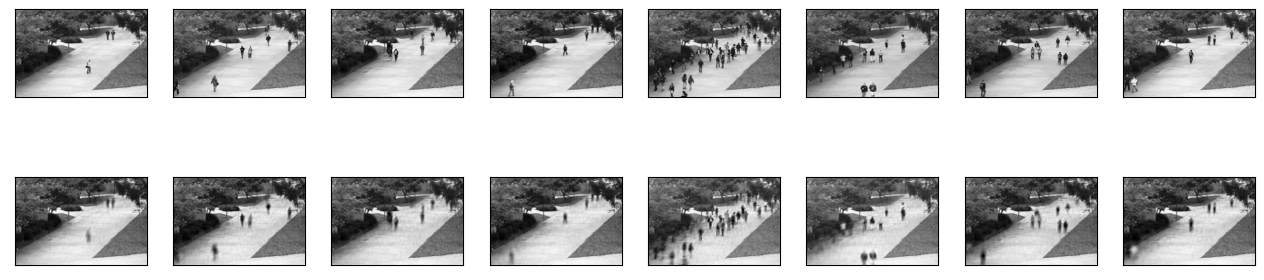

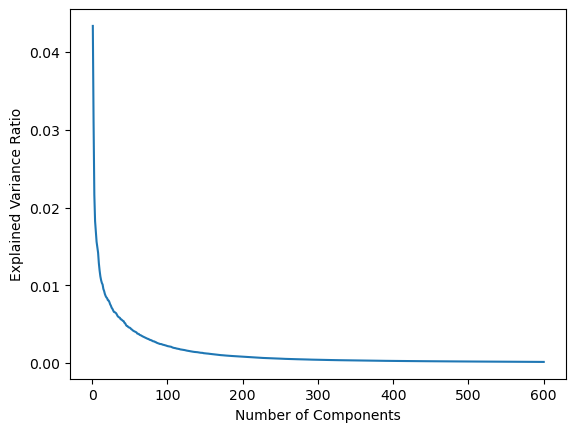

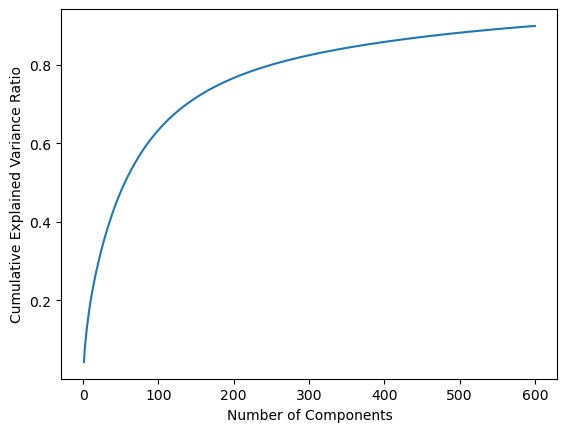

Reconstruction error is  0.00039033455





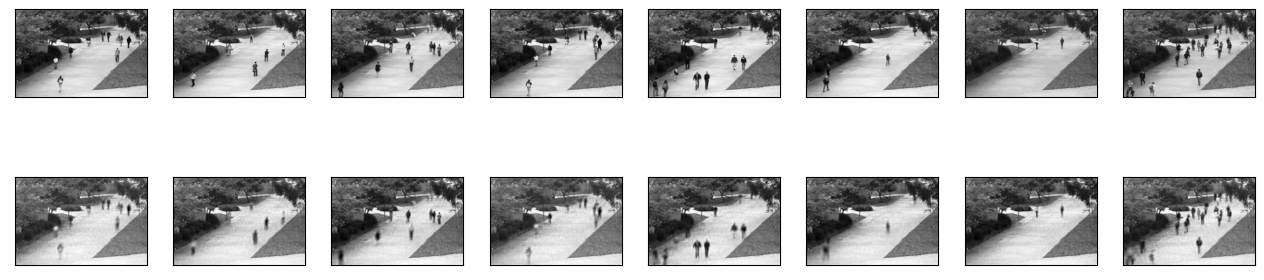

==========PCA TEST==========


OSError: -2

In [4]:


#cae.to(device)

def do_pca(batch_size, n_components, dataset):
    
    pca = PCA(n_components)

    # Create a dataloader to pass all the training data
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    images = next(iter(train_loader))

    transformed_images = pca.fit_transform(images.numpy().reshape(-1,160*240))
    reconstructed_images = pca.inverse_transform(transformed_images)
    

    #print(np.cumsum(pca.explained_variance_ratio_))

    plt.plot(np.arange(1,n_components+1), pca.explained_variance_ratio_)
    # Plotting using a log scale might show more information
    #plt.yscale('log')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.show()

    plt.plot(np.arange(1,n_components+1), np.cumsum(pca.explained_variance_ratio_))
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.show()
    



    reconstruction_error = mean_squared_error(images.numpy().reshape(-1,160*240), reconstructed_images)
    print('Reconstruction error is ', reconstruction_error)
    print("\n\n")

    plt.figure(figsize=(16, 4))
    for i in range(8):
        # Top row: show original faces
        plt.subplot(2,8,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i].reshape(160,240), cmap='Greys_r')
        # Bottom row: show reconstructions
        plt.subplot(2,8, 8+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(reconstructed_images[i].reshape(160,240), cmap='Greys_r')
    plt.show()

    
    
print("==========PCA TRAIN==========")
do_pca(6800, 200, dataset_train)
do_pca(6800, 400, dataset_train)
do_pca(6800, 600, dataset_train)






print("==========PCA TEST==========")
do_pca(7200, 600, dataset_train2)




In [ ]:
ae = Autoencoder()
cae = ConvAutoencoder()
cae2D = ConvAutoencoder2D()

#print(ae)
#print("==============Standard Autoencoder===========")
#outputs = train_AE(ae, dataset, max_epochs=30, print_steps=30)
#print("\n\n")

"""
numImgs=12;
for k in range(0, len(outputs), 9):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].numpy()    
    recon = outputs[k][2].numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
"""


print("==============ConvAutoencoder TRAIN==============")
outputs = train_AE(cae, dataset_train, max_epochs=30, print_steps=30)
print("\n\n")


numImgs=12;
for k in range(0, len(outputs), 9):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].cpu().numpy()    
    recon = outputs[k][2].cpu().numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
        
print("\n\n")
print("==============ConvAutoencoder TEST==============")
outputs = train_AE(cae, dataset_train2, max_epochs=30, print_steps=30)
print("\n\n")


numImgs=12;
for k in range(0, len(outputs), 9):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].cpu().numpy()    
    recon = outputs[k][2].cpu().numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])